In [50]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as confusion_matrix
import glob
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

In [51]:
#file path and format for dataset
pathname ='data/'
file_format = '*.csv'

#function to load and merge csv files for dataset
def load_merge_dataset(pathname,file_format):
    csv_files = Path(pathname).glob(file_format)
    pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True).to_csv("combined_slice_dataset.csv", index=False)  
    df=pd.read_csv("combined_slice_dataset.csv")
    df = df.drop(df.filter(regex='^Unnamed').columns,axis=1)
    df.columns = df.columns.str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.replace(' ','_').str.replace('%','pct').str.lower()
    return df

df=load_merge_dataset(pathname,file_format)
df=df.fillna(0)
df['slice_id'].unique()
df.shape



(6290, 31)

In [52]:
def convert_timestamp_to_networkLoad(timestamp):
    dt =pd.to_datetime(timestamp,unit='ms',utc=True).tz_convert("Europe/Rome")
    hour = dt.hour
    if hour >=17 and hour <=21:
        load = 'peak'
    elif hour >=0 and hour<7:
        load = 'night'
    else:
        load = 'off-peak'
    return hour,load

df[['hour','network_load']] = df['timestamp'].apply(convert_timestamp_to_networkLoad).apply(pd.Series)
column_names = [ 'timestamp','num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id',
       'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs',
       'dl_n_samples', 'dl_buffer_bytes', 'tx_brate_downlink_mbps',
       'tx_pkts_downlink', 'tx_errors_downlink_pct', 'dl_cqi', 'ul_mcs',
       'ul_n_samples', 'ul_buffer_bytes', 'rx_brate_uplink_mbps',
       'rx_pkts_uplink', 'rx_errors_uplink_pct', 'ul_rssi', 'ul_sinr', 'phr',
       'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n',
       'ul_turbo_iters','hour','network_load']

for col in column_names:
    print(col,"  ",df[col].unique())




timestamp    [1617070531726 1617070531975 1617070532225 ... 1617070529476 1617070529726
 1617070530010]
num_ues    [6 7 5 4 3 2 9]
imsi    [1010123456002 1010123456003 1010123456004]
rnti    [82 77 73]
slicing_enabled    [1]
slice_id    [2 0 1]
slice_prb    [ 5  6 39]
power_multiplier    [1]
scheduling_policy    [0]
dl_mcs    [ 4.12121   0.181818  0.       ...  6.19481   8.48148  13.125   ]
dl_n_samples    [ 33  22   0  72 127 125 166 244 159 106  99 130 200 147 104 194 177 186
 136 123 133 122 232 121 103 128 169 139  93 226 171 168 185 255 245 218
  95 144 153 152 161  98 105 227 170 135 112 179 180 258 117 111 176 141
 129 165 110 164 181 190 146 301  69 253 233 351 257 173 209 116 172  96
 118 302 217 155 276 124 160 137 192 113 334 213 120 131 126 150 229 199
 265 270 138 204 195 145 140  94 107 317 148 191 102  91 318 174  83 260
 311 256 115 206  80 287 119 212 231 288 158 230 246 167 332 162  92 280
 114 208  60 163  78 283 412 183 197 108 415 268 296 184 263 234 100 157
 228 2

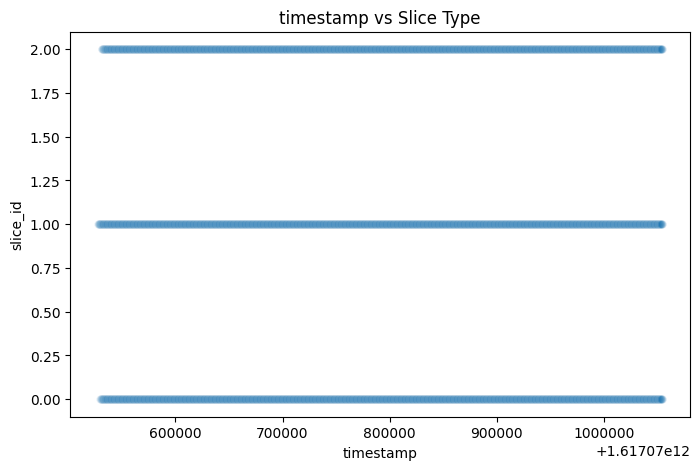

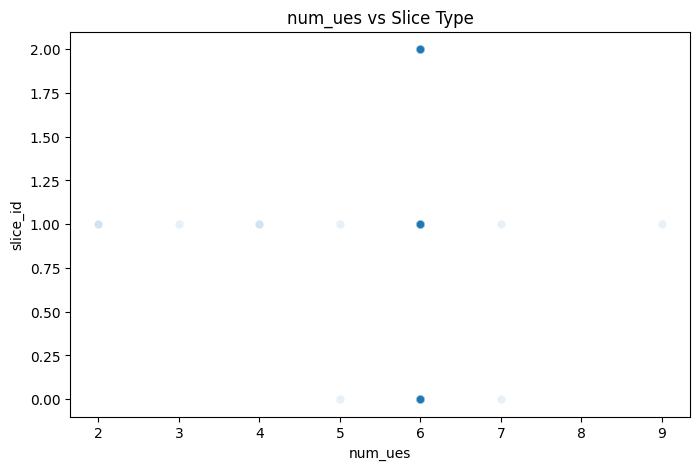

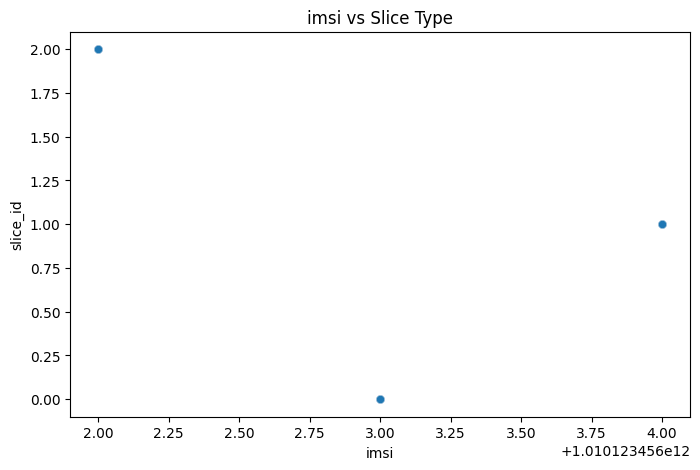

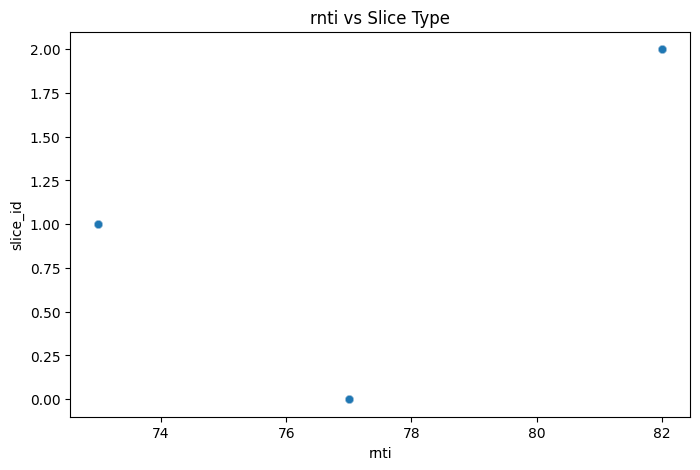

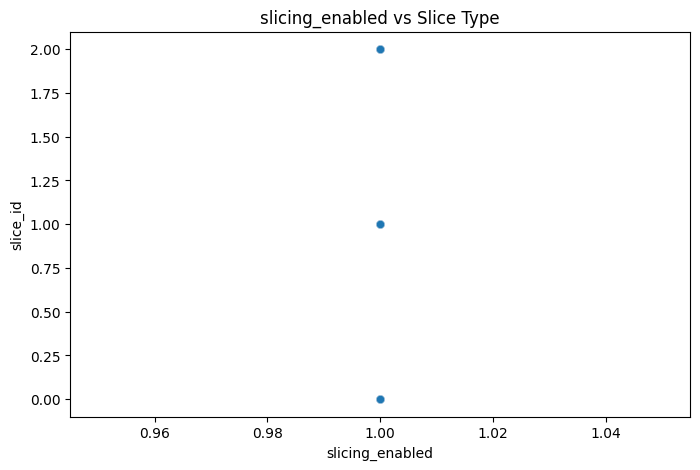

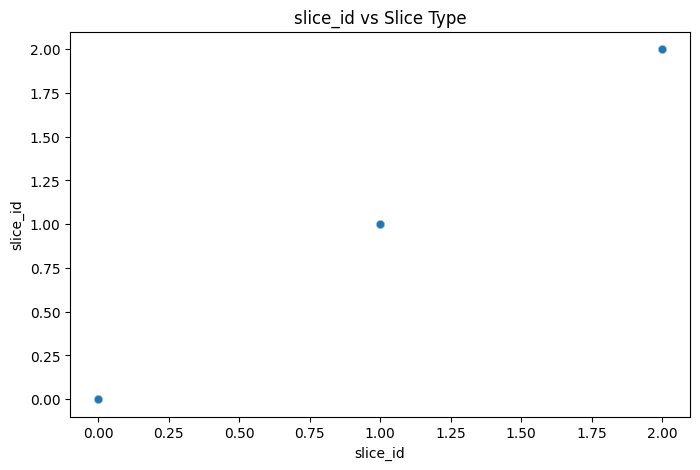

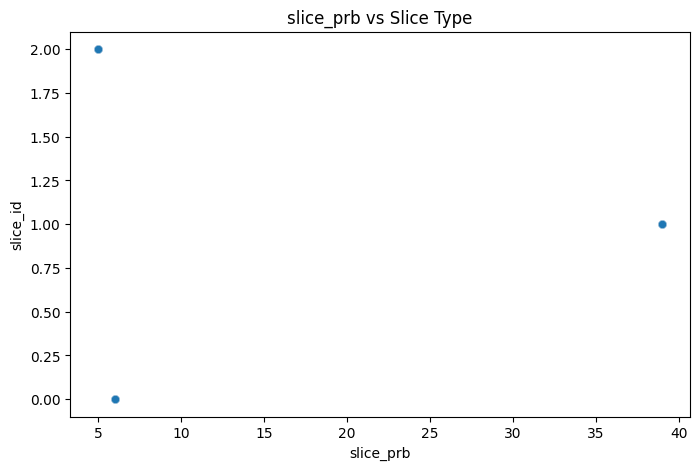

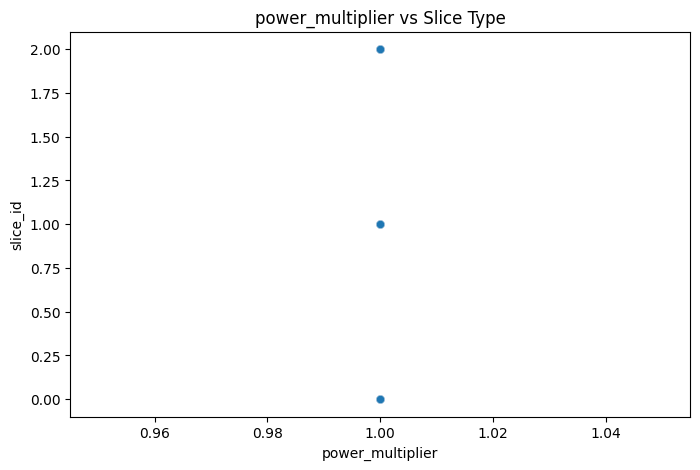

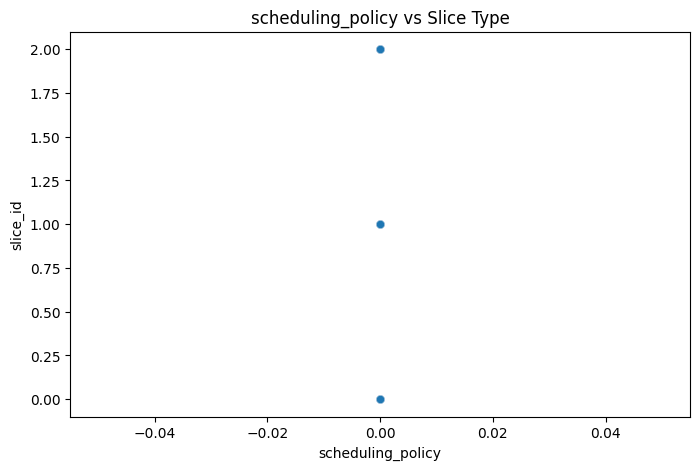

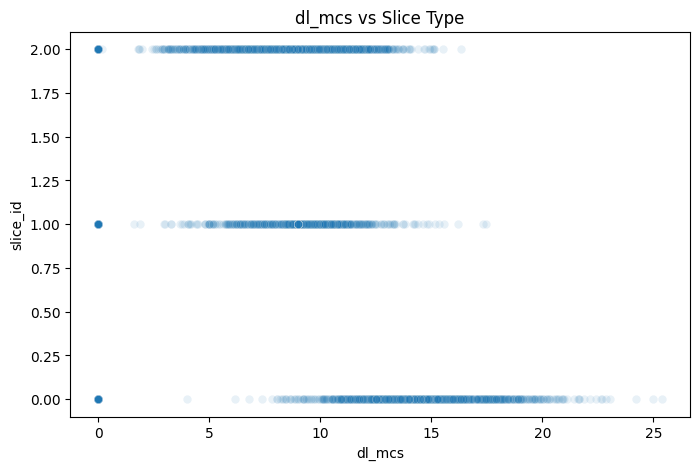

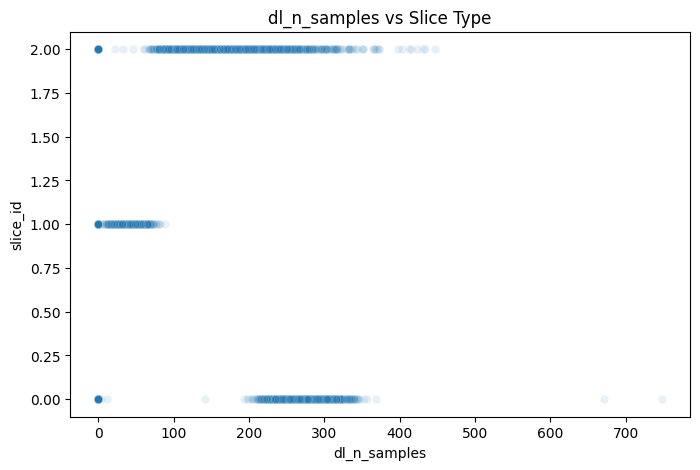

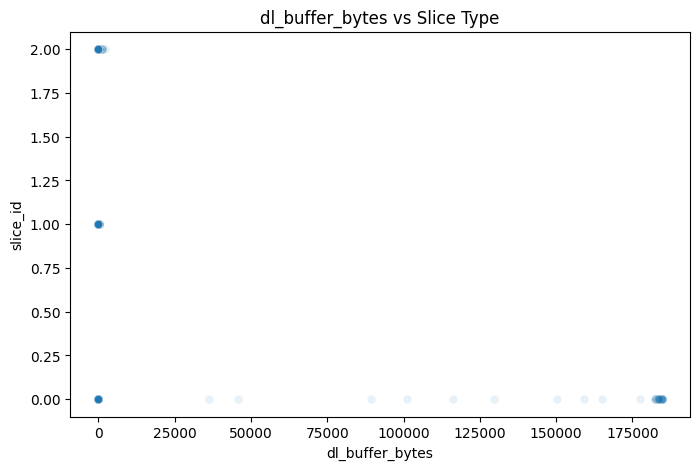

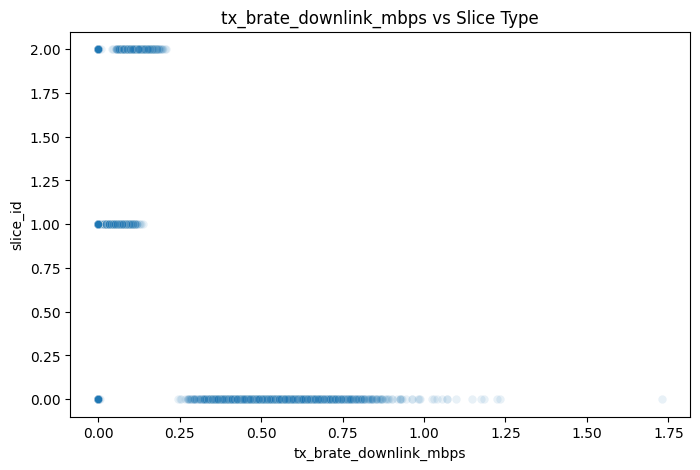

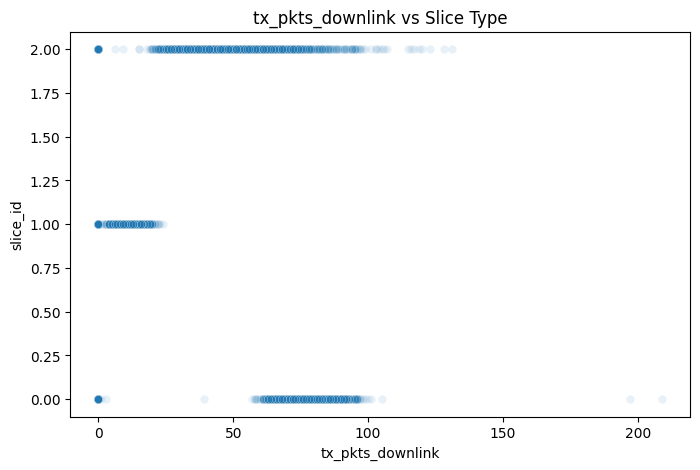

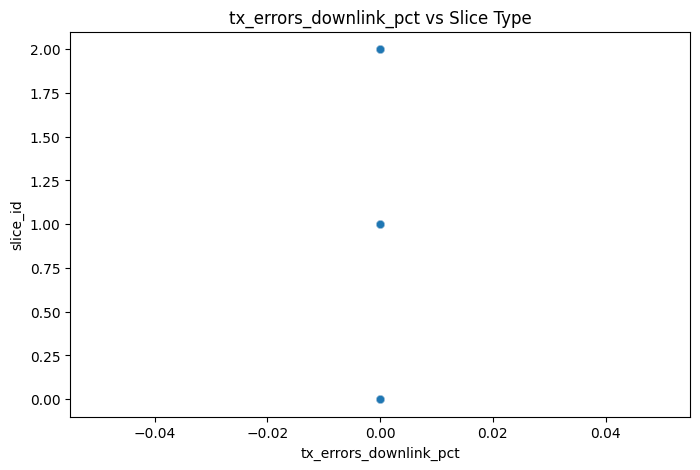

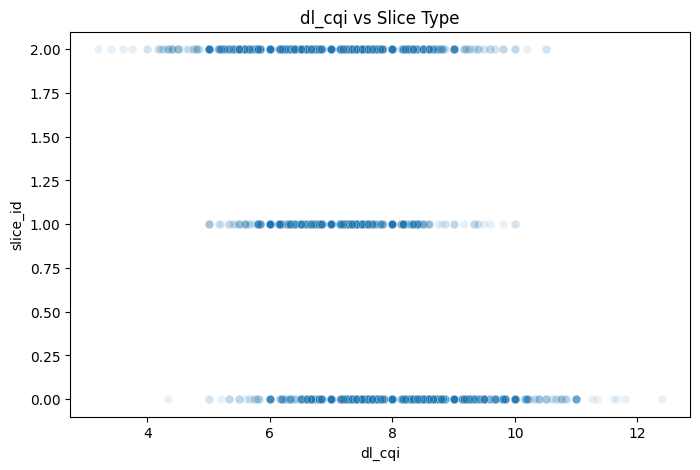

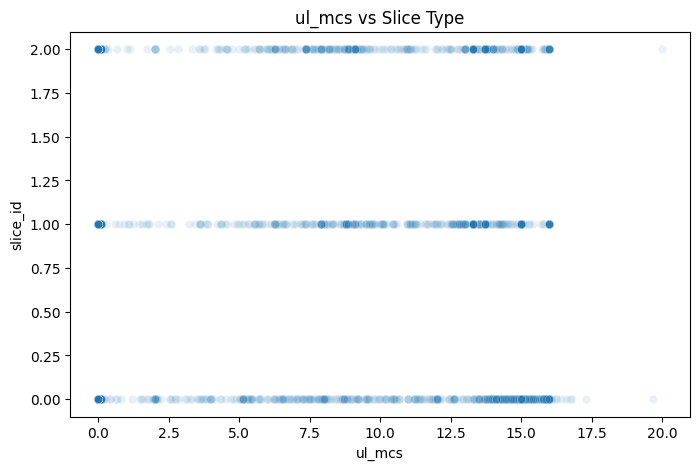

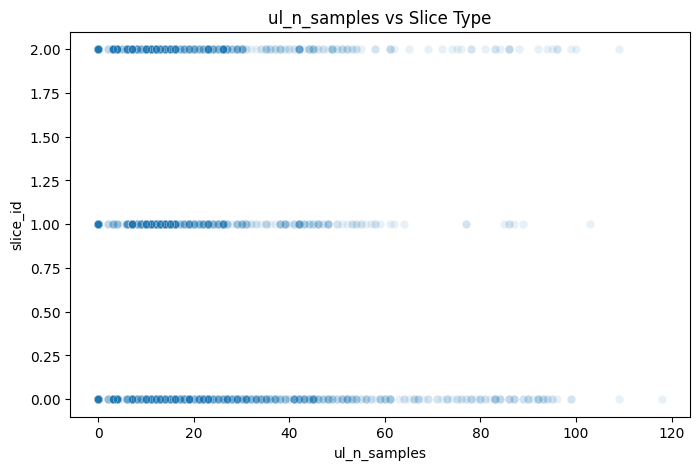

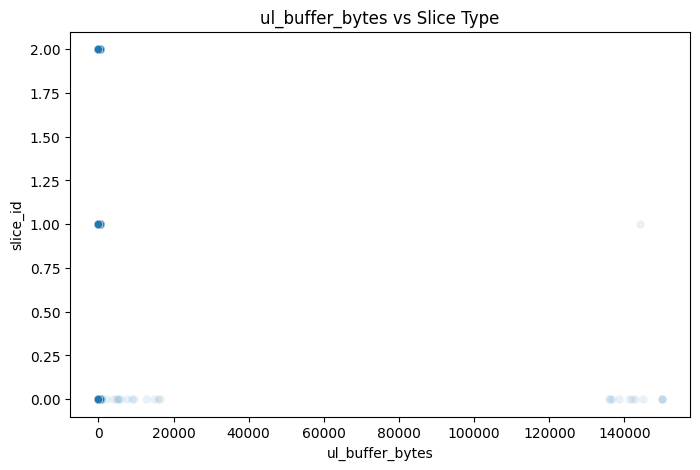

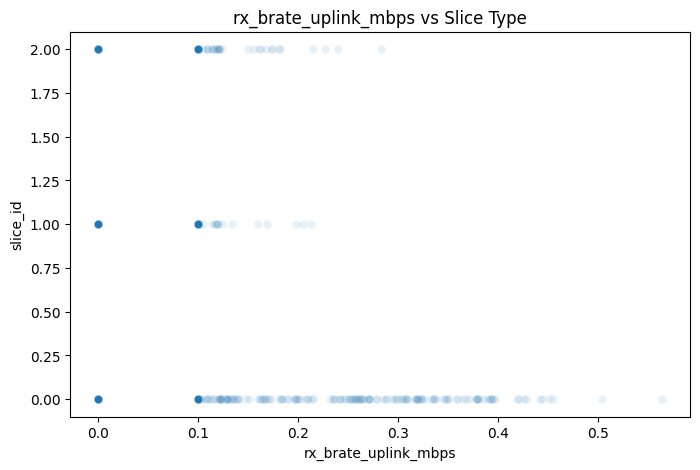

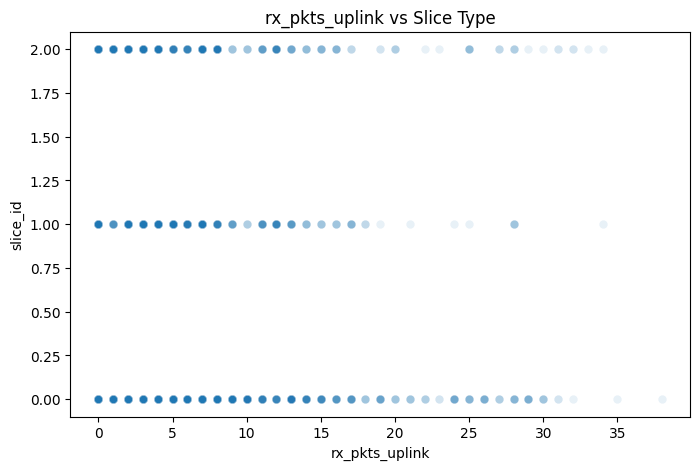

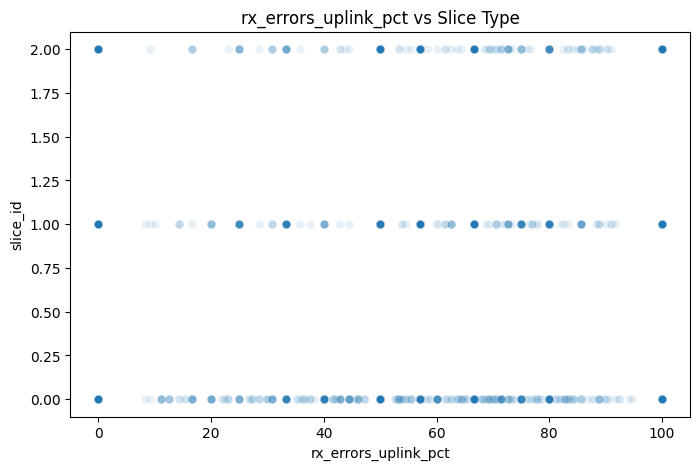

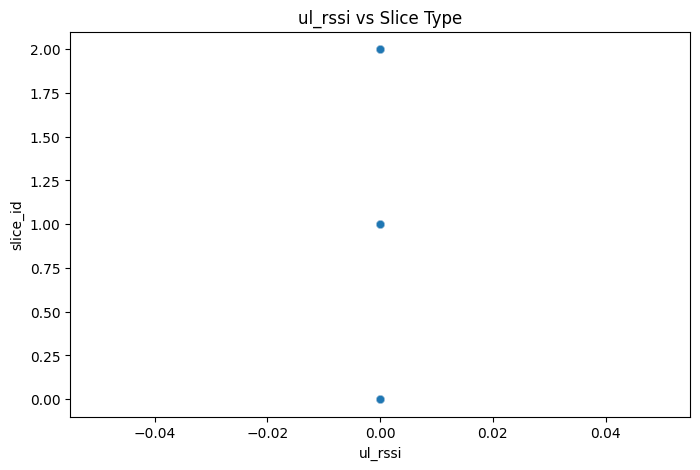

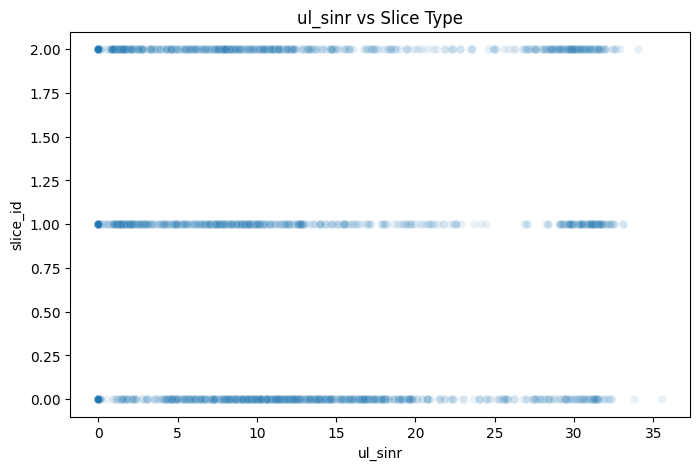

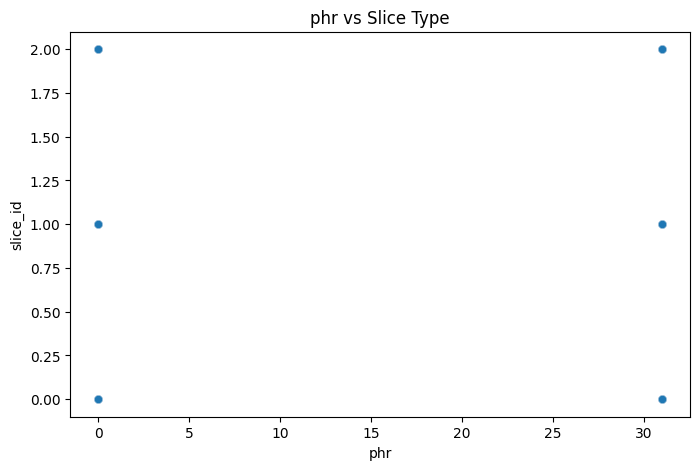

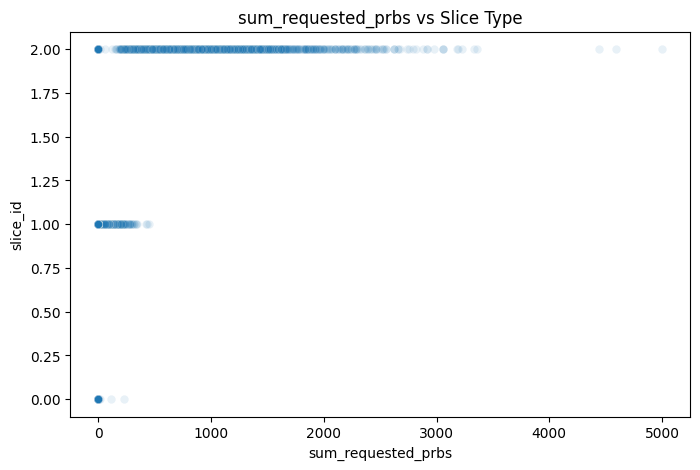

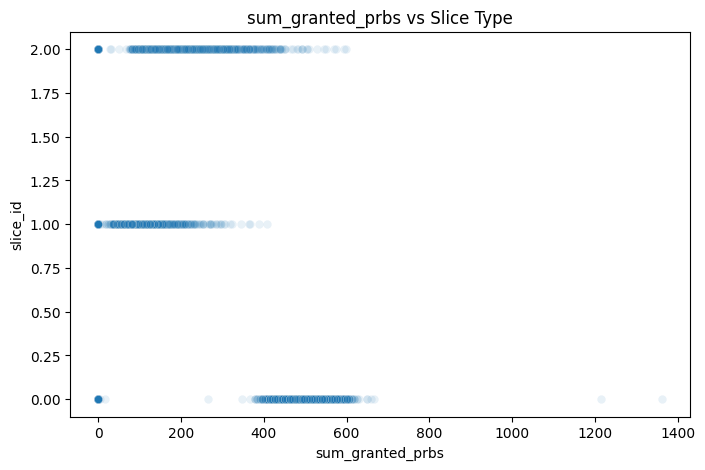

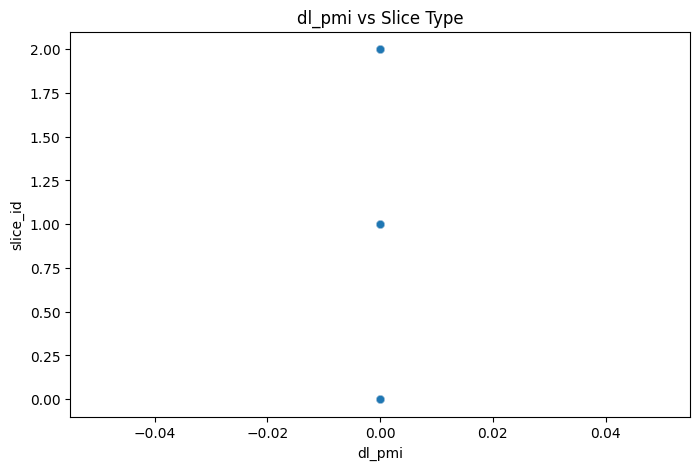

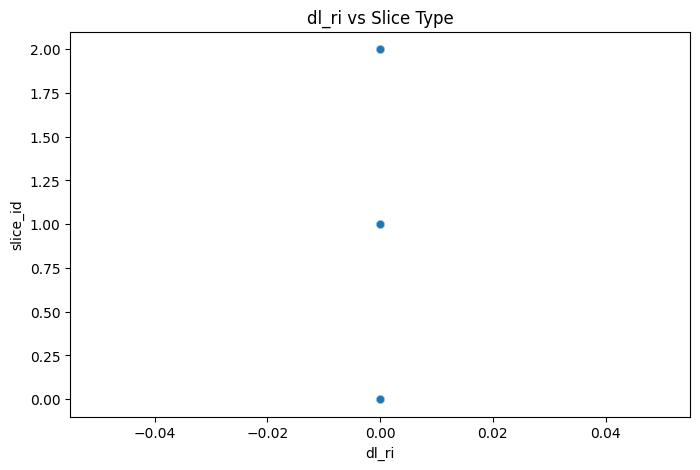

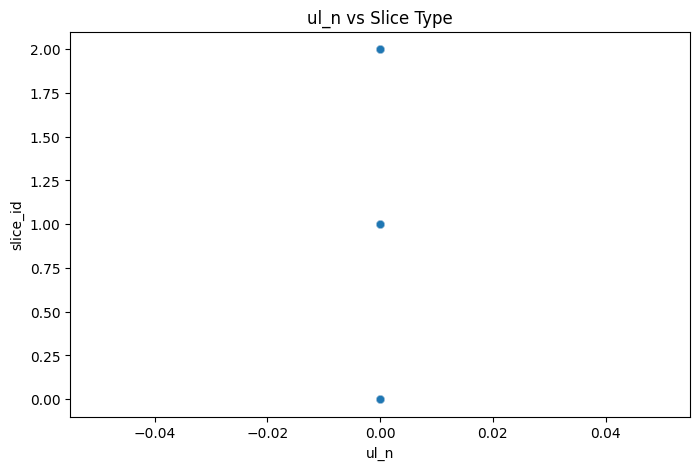

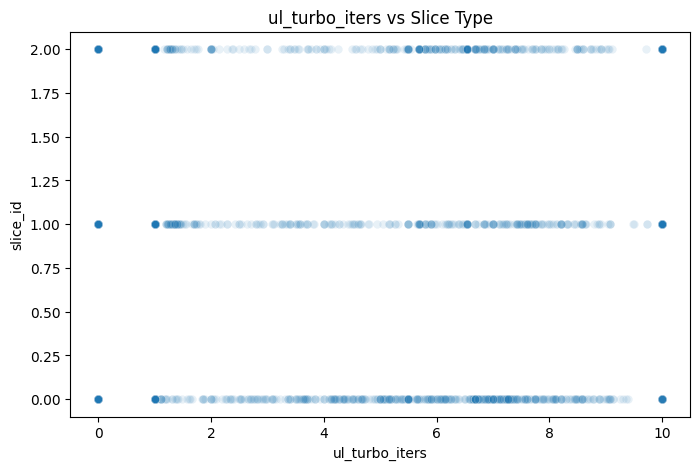

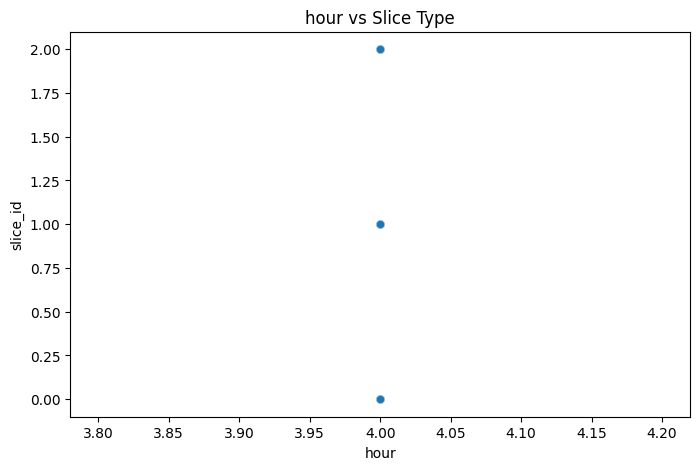

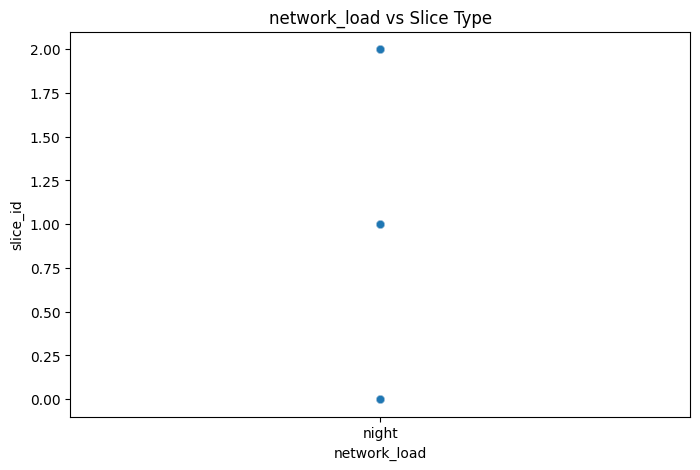

In [53]:
for col in column_names:
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        data=df,
        x=col,
        y=df.slice_id,
        alpha=0.1
    )
    #plt.xscale(col)
    plt.title(f"{col} vs Slice Type")
    plt.show()





In [54]:
df['network_load'].unique()



array(['night'], dtype=object)

Let's check if the dataset is balanced across slice types.

In [55]:
def check_classimbalance():
    class_imbalance_ratio = np.round(df.slice_id.value_counts().max()/df.slice_id.value_counts().min(),3)
    if(class_imbalance_ratio<2):
        print("Class is balanced,Imbalance Ratio : ", class_imbalance_ratio) 
    else:
        print("class is imbalanced,Imbalance ratio : ",class_imbalance_ratio) 

check_classimbalance()
def check_duplicates_in_dataset():
    duplicated_record_count = df.duplicated().sum()
    if(duplicated_record_count>0):
        print("Number of duplicates is ",duplicated_record_count)
        df.drop_duplicates()
        print("Duplicated records are successfully dropped")
    else:
        print("No duplicate records found as the duplicated record count is ",duplicated_record_count)

check_duplicates_in_dataset()

Class is balanced,Imbalance Ratio :  1.007
No duplicate records found as the duplicated record count is  0


Null check on columns - done . There are no null values in the dataset.
There are no duplicated values in the dataset.

(3774, 33)
(1258, 33)
(1258, 33)
slice_id
1    0.334499
0    0.333227
2    0.332273
Name: proportion, dtype: float64
slice_id
1    0.339163
2    0.333598
0    0.327239
Name: proportion, dtype: float64
slice_id
0    0.347377
1    0.333068
2    0.319555
Name: proportion, dtype: float64
slice_id
2    0.341017
0    0.337043
1    0.321940
Name: proportion, dtype: float64
Index(['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id',
       'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs',
       'dl_n_samples', 'dl_buffer_bytes', 'tx_brate_downlink_mbps',
       'tx_pkts_downlink', 'tx_errors_downlink_pct', 'dl_cqi', 'ul_mcs',
       'ul_n_samples', 'ul_buffer_bytes', 'rx_brate_uplink_mbps',
       'rx_pkts_uplink', 'rx_errors_uplink_pct', 'ul_rssi', 'ul_sinr', 'phr',
       'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n',
       'ul_turbo_iters', 'hour'],
      dtype='object')


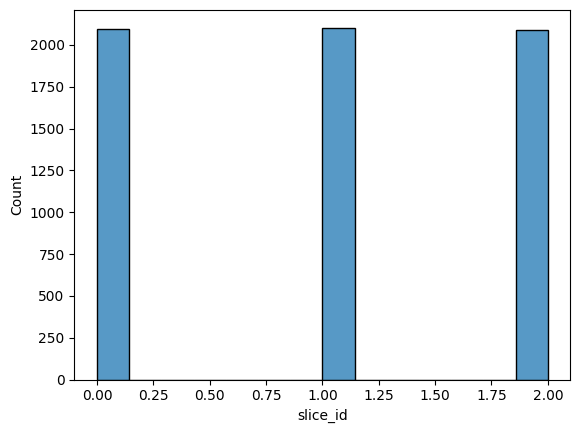

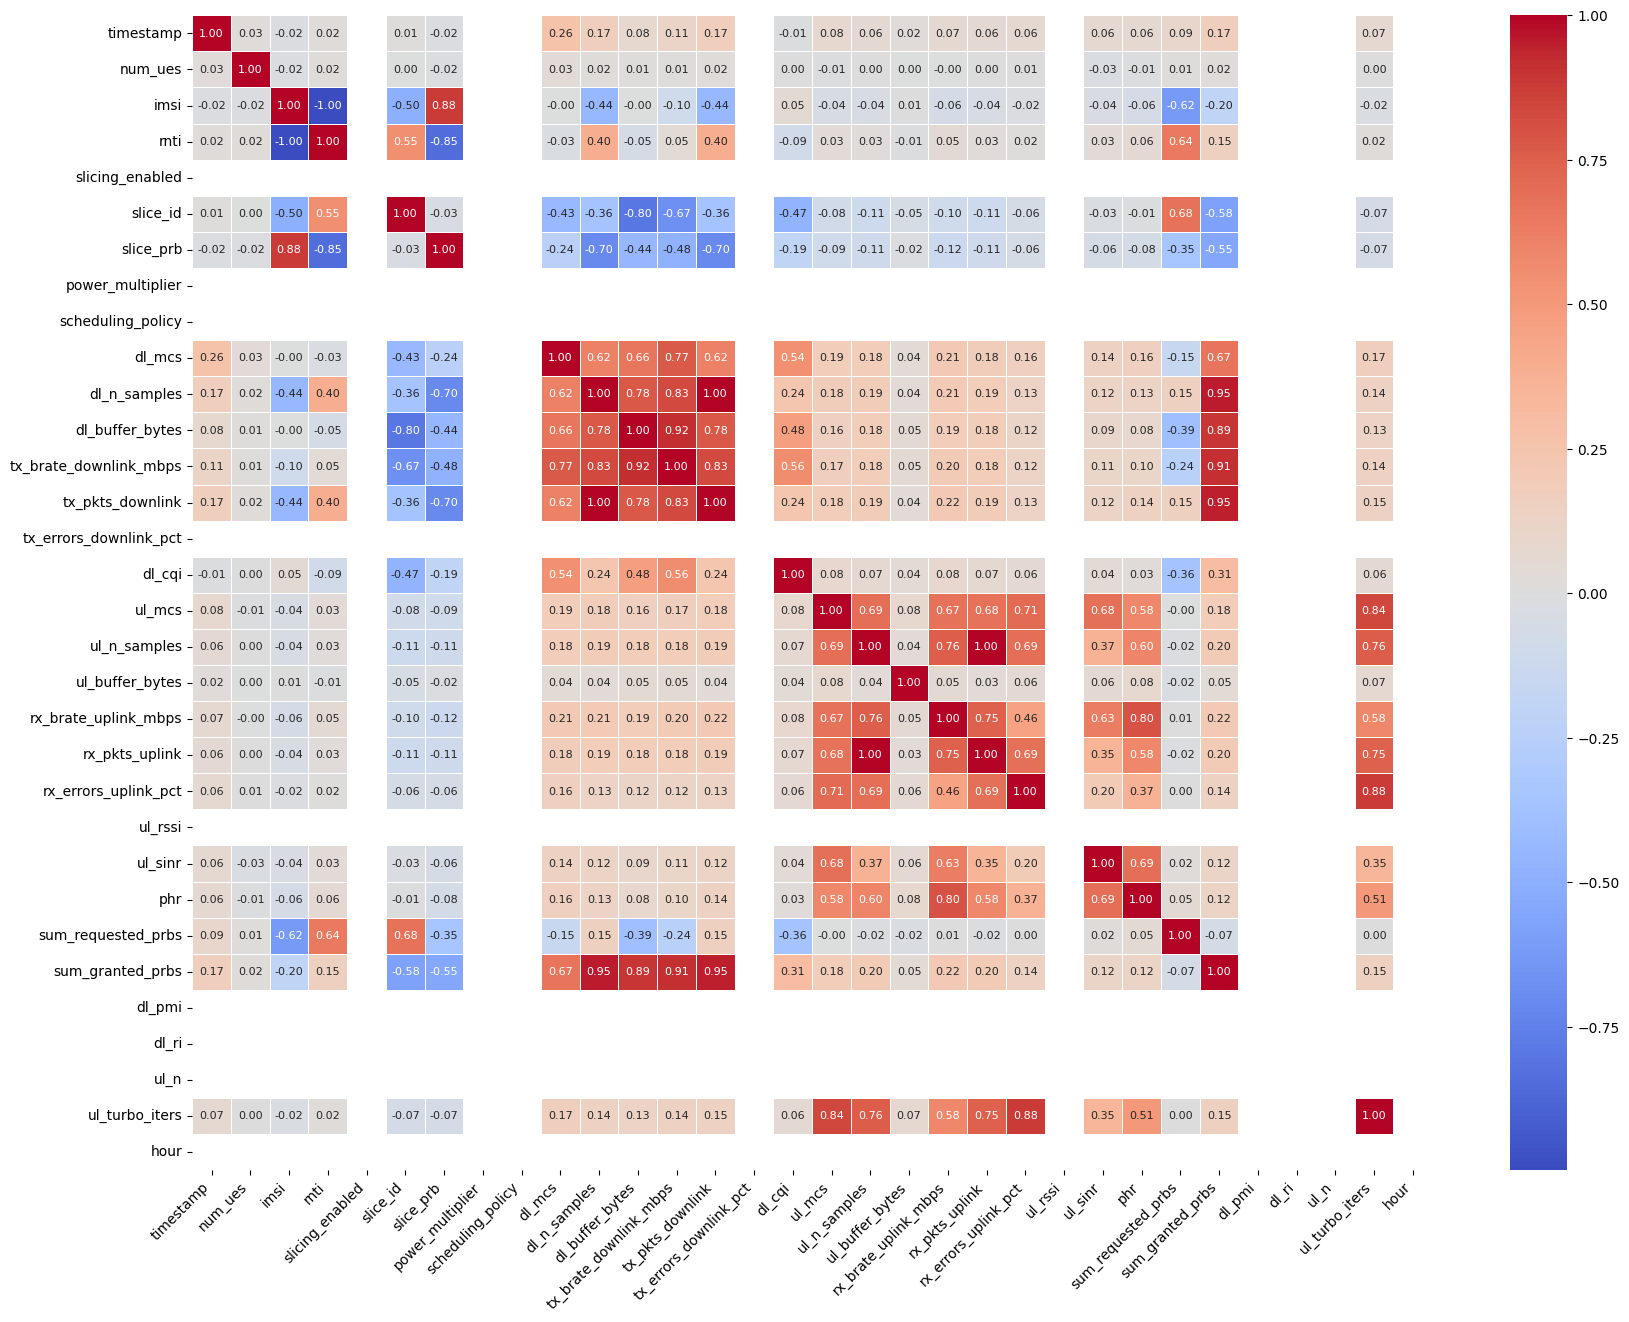

In [57]:
df_fulltrain , df_test= train_test_split(df,test_size=0.2,random_state=42)
df_train,df_val=train_test_split(df_fulltrain,test_size=0.25,random_state=42)
df_fulltrain = df_fulltrain.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)  
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

y_fulltrain = df_fulltrain['slice_id'].values
y_train = df_train['slice_id'].values
y_val = df_val['slice_id'].values
y_test = df_test['slice_id'].values

print(df["slice_id"].value_counts(normalize=True))
print(df_train["slice_id"].value_counts(normalize=True))
print(df_val["slice_id"].value_counts(normalize=True))
print(df_test["slice_id"].value_counts(normalize=True))
sns.histplot(df.slice_id)

# Plot the correlation matrix as a heatmap

numerical_columns = df.select_dtypes(include=[np.number]).columns
print(numerical_columns)
plt.figure(figsize=(20, 15)) # Make the canvas much larger
sns.heatmap(
    df_train[numerical_columns].corr(), 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    annot_kws={"size": 8},   # Smaller font for the numbers
    linewidths=0.5
)
plt.xticks(rotation=45, ha='right', fontsize=10) # Tilt labels for better fit
plt.yticks(fontsize=10)
plt.show()


In [ ]:
unique_counts=df.nunique()
static_cols =unique_counts[unique_counts<=1].index.tolist()
print(static_cols)
# Identify "quasi-static" columns (e.g., less than 0.1% variation)
quasi_static_cols = [col for col in df.columns if (df[col].nunique() / len(df)) < 0.001]
print(quasi_static_cols)

Let's split the dataset into training and testing sets.

In [ ]:
def remove_static_columns_from_dataset(column_names):
    for col in column_names:
        del df_train[col]
        del df_fulltrain[col]
        del df_val[col]
        del df_test[col]

columns_to_keep = ['dl_mcs', 'ul_sinr', 'tx_brate_downlink_mbps', 'dl_buffer_bytes','ul_turbo_iters', 'dl_cqi',
       'ul_n_samples','network_load']

column_names = [ 'timestamp','num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id',
       'slice_prb', 'power_multiplier', 'scheduling_policy', 
         'dl_n_samples', 
        'tx_errors_downlink_pct', 'ul_mcs', 'ul_buffer_bytes', 'rx_brate_uplink_mbps',
       'rx_pkts_uplink', 'rx_errors_uplink_pct', 'ul_rssi',  'phr',
       'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n','tx_pkts_downlink','hour'
       ]
remove_static_columns_from_dataset(column_names)

In [ ]:
df["hour"].value_counts().sort_index()


In [ ]:
# Quick check for static features
def check_static_features(df):
    static_cols = []
    for col in df.columns:
        if df[col].nunique() == 1:
            static_cols.append(col)
            print(f"Static: {col} = {df[col].iloc[0]}")
    return static_cols

# Check variance
def check_low_variance(df, threshold=0.01):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    low_var = []
    for col in numeric_cols:
        variance = df[col].var()
        if variance < threshold:
            low_var.append(col)
            print(f"Low variance: {col}, var = {variance:.6f}")
    return low_var

check_static_features(df)
check_low_variance(df)

In [ ]:

def train_model(df,y,C):
    pipeline = Pipeline([
        ("vectorizer", DictVectorizer(sparse=False)),
        ("scaler", StandardScaler()),  
        ("model", LogisticRegression(C=C,max_iter=1000))
    ])

    x=df.to_dict(orient="records")
    pipeline.fit(x, y)
    return pipeline

pipeline = train_model(df_train,y_train,10)
def test_model(pipeline,df,y):
    x_val =df.to_dict(orient="records")
    y_pred = pipeline.predict(x_val)
    y_pred_proba = pipeline.predict_proba(x_val)
    return y_pred,y_pred_proba

def print_classification_report(y_pred,y_pred_proba,actual_y):
    print(classification_report(actual_y, y_pred))
    print("*******************************************************")
    print(confusion_matrix(actual_y, y_pred))
    print("roc_auc score ",roc_auc_score(actual_y, y_pred_proba,multi_class="ovr"))

y_pred_val,y_pred_proba_val = test_model(pipeline,df_val,y_val)
print_classification_report(y_pred_val,y_pred_proba_val,y_val)

y_pred_test,y_pred_proba_test = test_model(pipeline,df_test,y_test)
print_classification_report(y_pred_test,y_pred_proba_test,y_test)


Let's do cross validation with 5 fold and check the performance of the model.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

model= LogisticRegression(solver='newton-cg')
dv = DictVectorizer(sparse=False) 
X_dict=df_fulltrain.to_dict(orient='records')
X=dv.fit_transform(X_dict)

n_splits =5
roc_scores = []
std_deviations = []
reg_params=[0.1,0.01,1.0,10,100,200]
for c in reg_params:
    kfold = KFold(n_splits,shuffle=True,random_state=42)
    scores = cross_val_score(model,X,y_fulltrain,cv=kfold,scoring='roc_auc_ovr')
    std_deviations.append(scores.std())
    roc_scores.append(scores)
    print("C =",c,"roc_auc_ovr =",scores.mean())
    print("Standard Deviation =",scores.std())


    


c=10, roc_auc score is 0.9714. Let's train the model with vali+train dataset and test it on test dataset

In [ ]:
Model_ROC_AUC_scores = []
pipeline =train_model(df_fulltrain,y_fulltrain,10)
y_pred,y_pred_proba=test_model(pipeline,df_test,y_test)
print_classification_report(y_pred,y_pred_proba,y_test)
Model_ROC_AUC_scores.append(("Logistic Regression",np.round(roc_auc_score(y_test, y_pred_proba,multi_class="ovr"),3)))

With full train and test data, the model is able to predict the slice_id with an accuracy of 0.86 and ROC_AUC of 0.96
It is stable and consistent across multiple runs and cross validation test also confirms that model is stable and consistent.

In [ ]:
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.metrics import accuracy_score

dv= DictVectorizer(sparse=True)
train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dict)

auc_scores = []
depths = range(1, 21)
for max_depth in depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred) 
    roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
    print("Decision Tree with depth " \
    f"{max_depth} Accuracy:", accuracy,"ROC AUC:", roc_auc)

    auc_scores.append(roc_auc)

# Plotting the AUC scores
plt.figure(figsize=(10, 6))
plt.plot(depths, auc_scores, marker='o', linestyle='-', color='b', label='AUC Score')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Tree Depth for Decision Tree Classifier')
plt.grid(True)
plt.xticks(depths)  # Ensure we show all depth values on the x-axis
plt.legend()
plt.show()

Let's narrow down for  depth=4,5,6,7,8as the roc_auc is maximum(0.98) after which it decreases.

In [ ]:
scores = []
for max_depth in [4,5, 6, 7, 8]:
    for min_samples_leaf in [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred) 
        roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
        scores.append({
            'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })
        print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, Accuracy: {accuracy}, ROC AUC: {roc_auc}")
df_scores = pd.DataFrame(scores)
pivot_table = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='roc_auc')
sns.heatmap(pivot_table, annot=True, fmt=".3f") 

max_depth =6 and min_samples_leaf=3 roc_auc of 0.983.Lets test with test data to see if the model doesnt overfit.
We get the same results with test data as well.

In [ ]:

dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=3, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
accuracy = accuracy_score(y_val, y_pred) 
roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
print("Decision Tree with validation data Accuracy:", accuracy,"ROC AUC:", roc_auc)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))
Model_ROC_AUC_scores.append(('Decision Tree', np.round(roc_auc,3)))
X_train.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier

scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred) 
    roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val), multi_class='ovr')
    scores.append({
        'n_estimators': n,
        'accuracy': accuracy,
        'roc_auc': roc_auc
    })
    print(f"n_estimators: {n}, Accuracy: {accuracy}, ROC AUC: {roc_auc}")
df_scores = pd.DataFrame(scores)
plt.plot(df_scores['n_estimators'], df_scores['roc_auc'], marker='o')
plt.xlabel('Number of Estimators')  
plt.ylabel('ROC AUC')
plt.title('Random Forest Classifier ROC AUC vs Number of Estimators')
plt.show()  
print(export_text(rf.estimators_[0], feature_names=list(dv.get_feature_names_out())))

With 50 estimators in ensemble model, we are able to get 0.987 roc_auc score

In [ ]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

df_val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(df_val_dicts)
y_pred = rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred) 
roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val), multi_class='ovr')
print("Random Forest with Validation Data Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))
Model_ROC_AUC_scores.append(('Random Forest', np.round(roc_auc, 3)))

df_test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(df_test_dicts)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')
print("Random Forest with TestData Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Basic XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Evaluate with cross-validation
scores = cross_val_score(xgb_model, X, y_fulltrain, cv=5, scoring='roc_auc_ovr')
print(f"XGBoost ROC-AUC: {scores.mean():.3f} (±{scores.std():.3f})")
Model_ROC_AUC_scores.append(("XGBoost", np.round(scores.mean(),3)))



In [ ]:
print(Model_ROC_AUC_scores)
Model, ROC_AUC_Score = zip(*Model_ROC_AUC_scores)
# Plotting the ROC AUC comparison using curves (line plot)
plt.figure(figsize=(10, 6))

# Plot the ROC AUC scores for each model
plt.plot(Model, ROC_AUC_Score, marker='o', linestyle='-', color='b', label='ROC AUC Score')

# Add labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('ROC AUC Score', fontsize=12)
plt.title('Model ROC AUC Score Comparison - Curves', fontsize=14)

# Add a legend to identify the line
plt.legend(title='ROC AUC Scores', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

From the graph it is clear that xgboost has the best performance and in network slicing even a small increase in performance can lead to a significant improvement in the overall system performance.
Let's finetune hyperparameters in XGBoost using GridSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(5, 12),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 7),
    'gamma': uniform(0, 0.3)
}

random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42),
    param_dist,
    n_iter=100,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X, y_fulltrain)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")

# Use the best model
best_model = random_search.best_estimator_



Through RandomSearchCV the best parameters are:
Best parameters: {'colsample_bytree': np.float64(0.7160455890242107), 'gamma': np.float64(0.2875624490649595), 'learning_rate': np.float64(0.17942862881911797), 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 405, 'subsample': np.float64(0.9030309713272909)}
Best score: 0.9913

In [ ]:
best_model.fit(X, y_fulltrain)

df_test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(df_test_dicts)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
y_pred_proba=best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("XGBoost with TestData Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))
print_classification_report( y_pred,y_pred_proba,y_test)


XGBoost with TestData Accuracy: 0.932 ROC AUC: 0.99
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       424
           1       0.89      0.93      0.91       405
           2       0.95      0.89      0.92       429

    accuracy                           0.93      1258
   macro avg       0.93      0.93      0.93      1258
weighted avg       0.93      0.93      0.93      1258

*******************************************************
[[413  10   1]
 [  8 378  19]
 [ 11  37 381]]
roc_auc score  0.9899438749996406


array([[9.9977356e-01, 3.5030676e-05, 1.9140946e-04],
       [3.2514319e-04, 4.0737255e-03, 9.9560118e-01],
       [3.7568295e-04, 2.7469501e-03, 9.9687731e-01],
       ...,
       [7.8950811e-04, 1.3748319e-01, 8.6172736e-01],
       [9.9874473e-01, 6.3033905e-05, 1.1922283e-03],
       [9.9950099e-01, 3.6950616e-05, 4.6199444e-04]],
      shape=(1258, 3), dtype=float32)